In [1]:
import xml.etree.ElementTree as ET
import numpy as np
import cv2
import pandas as pd
import imgaug as ia
import os
import random
from PIL import Image
import json
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

In [6]:
file_name = 'maksssksksss0.png'
xml_file = ET.parse("annotations/" + file_name[:-4] + ".xml")
root = xml_file.getroot()

In [3]:
#Categories list for COCO conversion later
categories = {"without_mask" : 1,
             "with_mask" : 2,
             "mask_weared_incorrect" : 3}

In [71]:
#Display the bounding boxes on an image


image = cv2.imread("images/" + file_name)


bbox_list = []
category_array = np.array([])
for obj in root.findall("object"):
    bndbox = obj.find("bndbox")
    category = obj.find("name").text
    
    x1 = int(bndbox.find("xmin").text)
    y1 = int(bndbox.find("ymin").text)
    x2 = int(bndbox.find("xmax").text)
    y2 = int(bndbox.find("ymax").text)
    
    bbox = BoundingBox(x1=x1, y1=y1, x2=x2, y2=y2)
    bbox_list.append(bbox)
    category_array = np.append(category_array, np.array([categories[category]])).astype(np.int32)
    
# print(bbox_list.to_xyxy_array())
colors = {1 : [255,0,0], 2 : [0,120,150], 3 : [255,0,255]}
output_image = image

for category in np.arange(1,4):
    indexes = np.where(category_array == category)[0]
    if len(indexes) > 0:
        category_box = []
        for index in indexes:
            category_box.append(bbox_list[index])
            
        category_box = BoundingBoxesOnImage(category_box, shape=image.shape)
        print(category_box.to_xyxy_array())
        output_image = category_box.draw_on_image(output_image, size=4,
                                                  color=colors[category])

[[ 79. 105. 109. 142.]
 [325.  90. 360. 141.]]
--------------------
[[185. 100. 226. 144.]]
--------------------


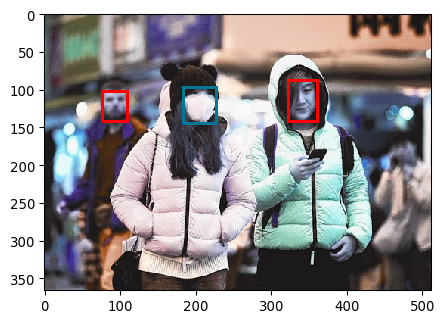

In [75]:
#Sample image
ia.imshow(output_image)

In [13]:
#Time to convert annotations into a single csv file
data_df = pd.DataFrame(columns=["filename", "category", "x1", "y1", "x2", "y2"])
filenames = os.listdir("annotations")

for filename in filenames:
    xml_file = ET.parse("annotations/" + filename)
    root = xml_file.getroot()

    for obj in root.findall("object"):
        bndbox = obj.find("bndbox")
        category = int(categories[obj.find("name").text])

        x1 = int(bndbox.find("xmin").text)
        y1 = int(bndbox.find("ymin").text)
        x2 = int(bndbox.find("xmax").text)
        y2 = int(bndbox.find("ymax").text)
        
        data_df.loc[len(data_df)] = [filename[:-4] + ".png", category, x1, y1, x2, y2]

In [14]:
data_df.head()

,filename,category,x1,y1,x2,y2
0,maksssksksss0.png,1,79,105,109,142
1,maksssksksss0.png,2,185,100,226,144
2,maksssksksss0.png,1,325,90,360,141
3,maksssksksss1.png,2,321,34,354,69
4,maksssksksss1.png,2,224,38,261,73


In [15]:
#get filenames + shuffle + separate into train, val, test

filenames = [x[:-4] + ".png" for x in filenames]
random.shuffle(filenames)
len(filenames)

853

In [16]:
train_files = filenames[:597] #70%
val_files = filenames[597:672] #10%
test_files = filenames[672:] #20%

validate = train_files + val_files + test_files
len(set(validate))

853

In [17]:
train_df = pd.DataFrame(columns=data_df.columns.values)
val_df = pd.DataFrame(columns=data_df.columns.values)
test_df = pd.DataFrame(columns=data_df.columns.values)

for filename in train_files:
    temp_df = data_df[data_df["filename"] == filename]
    train_df = pd.concat([train_df, temp_df])
    
for filename in val_files:
    temp_df = data_df[data_df["filename"] == filename]
    val_df = pd.concat([val_df, temp_df])
    
for filename in test_files:
    temp_df = data_df[data_df["filename"] == filename]
    test_df = pd.concat([test_df, temp_df])
    
#validate
len(set(list(test_df["filename"])))

181

In [18]:
#Convert to COCO function

def to_coco(df, coco_categories):
    coco = {
    "info" : {"author" : "Johan"},
    "images" : [],
    "annotations" : [],
    "licenses" : {"author" : "Johan"},
    "categories" : coco_categories
    }


    annot_idx = 1

    temp_idx = 1

    for idx, file_det in enumerate(filenames):
        img = Image.open("images/" + file_det)

        width, height = img.size

        temp_df = df[df["filename"] == file_det]

        coco["images"].append({
            "file_name" : file_det,
            "id" : idx,
            "height" : height,
            "width" : width
        })


        annotations = []

        for _, annot in temp_df.iterrows():

            category = annot["category"]


            bbox_xyxy = [annot["x1"], annot["y1"], annot["x2"], annot["y2"]]
            bbox_xywh = [float(bbox_xyxy[0]), float(bbox_xyxy[1]),
                        float(bbox_xyxy[2]) - float(bbox_xyxy[0]),
                        float(bbox_xyxy[3]) - float(bbox_xyxy[1])]

            segmentation = [bbox_xyxy[0], bbox_xyxy[1],
                            bbox_xyxy[2], bbox_xyxy[1],
                            bbox_xyxy[2], bbox_xyxy[3],
                            bbox_xyxy[0], bbox_xyxy[3]]


            annot_det = {
                "bbox" : bbox_xywh,
                "area" : (bbox_xyxy[3] - bbox_xyxy[1]) * (bbox_xyxy[2] - bbox_xyxy[0]),
                "segmentation" : [segmentation],
                "id" : annot_idx,
                "category_id" : category,
                "iscrowd" : 0,
                "image_id" : idx
            }

            coco["annotations"].append(annot_det)

            annot_idx += 1
        
        
    return coco

In [19]:
coco_category = [{
        "supercategory" : "face",
        "id" : 1,
        "name" : "with_mask"
    },
    {
        "supercategory" : "face",
        "id" : 2,
        "name" : "without_mask"
    },
    {
        "supercategory" : "face",
        "id" : 3,
        "name" : "mask_weared_incorrect"
    }]

train_coco = to_coco(train_df, coco_category)

with open("coco_train_set.json", "w+") as f:
    json.dump(train_coco, f)
    
val_coco = to_coco(val_df, coco_category)

with open("coco_val_set.json", "w+") as f:
    json.dump(val_coco, f)
    
    
test_coco = to_coco(test_df, coco_category)

with open("coco_test_set.json", "w+") as f:
    json.dump(test_coco, f)